#  Disentangled Sequential Variational Autoencoder using Tensorflow Probability

## Introduction

> This notebook is in very early stages of development and is not ready for public consumption.
When it is complete...

### Definition

Here we develop and test a disentangled sequential variational autoencoder. Let's break that down.

An **autoencoder** first encodes an input into a low-dimensional latent representation (a.k.a. compress, bottleneck), and from there decodes (a.k.a. generates) an output that resembles the input.

As our input is a multidimensional timeseries or sequence, and we use sequence-based methods like recurrent LSTM, this is called a **sequential autoencoder**.

As the inputs to the decoder are not deterministic variables, but are prescribed to be random variables (typically gaussian), this is called **variational**.

Finally, the training is designed so that the model learns to encode a latent representation that is split into features that **disentangle** time-dependent features (dynamics) and static features (content / context). Note that disentangled auto-encoders are by necessity variational, so we could drop the implied "variational" from our title. Alternatively, the disentanglement is often parameterized by a $\beta$ , so this could also be called a $\beta$-VAE.

### Application

An autoencoder can be trained in a self-supervised manner. That is, we don't need to care about the data labels to train it. This is greate because labeling data is often the most difficult part about getting training data.

Once trained, there are several applications for such a model.

The decoder part of the model is generative: we can provide an initial condition and then generate a realistic signal. For brain signals, this might be a useful tool to understand the model. In other domains, this can be used to generate animations / audio / video with e.g. the same movements, but the characteristics of the object changes.

The encoder part of the model takes a real input and compresses it to a meaningful latent representation. We know it is meaningful because it is sufficient to generate the input. These latent feature vectors are much more tractable as inputs into a simple decoder. Thus, the autoencoder can first be trained using all unlabeled data, then the encoder part can be transferred as the top layers of a new classification model that is further trained on a smaller labeled data set.

### Resources

[Li and Mandt, ICML 2018](https://arxiv.org/pdf/1803.02991.pdf)

[TF Probability examples](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/disentangled_vae.py)

## Prepare Notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os
import sys


try:
    # See if we are running on google.colab
    from google.colab import files
    %tensorflow_version 2.x
    os.chdir('..')
    
    if not (Path.home() / '.kaggle').is_dir():
        # Configure kaggle
        uploaded = files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        if 'kaggle.json' in uploaded.keys():
            !mkdir -p ~/.kaggle
            !mv kaggle.json ~/.kaggle/
            !chmod 600 ~/.kaggle/kaggle.json

    if Path.cwd().stem != 'IntracranialNeurophysDL':
        if not (Path.cwd() / 'IntracranialNeurophysDL').is_dir():
            # Download the workshop repo and change to its directory
            !git clone --recursive https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
        
    !pip install git+https://github.com/SachsLab/indl.git
    !pip install -q kaggle
    IN_COLAB = True

except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfkl
from tensorflow.keras import backend as K
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

In [4]:
if IN_COLAB:
    plt.style.use('dark_background')
plt.rcParams.update({
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'lines.linewidth': 2,
    'lines.markersize': 5,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 18,
    'figure.figsize': (6.4, 6.4)
})

## Prepare Data

While I'm figuring this out, I'll use a contrived dataset. Let's assume that we have N_LATENT different latent variables. Each latent variable evolves over time. The evolution of each latent (i.e., its dynamics) over time is described by a sinusoid. The sinusoid is modulated by a sigmoid function with amplitude conditioned on the trial label, of which there are N_CLASSES distinct classes. The evolved conditionally-dependent latent variables are then mixed to yield N_SENSORS sensor-space signals, using a static mixing matrix.

In [5]:
from indl.misc.sigfuncs import sigmoid
from functools import partial


N_LATENTS = 4
N_SENSORS = 32
N_CLASSES = 5
FS = 64
DURATION = 2  # seconds
n_timesteps = int(DURATION * FS)

np.random.seed(66)
x = np.arange(n_timesteps) / FS
lat_freqs = np.random.uniform(low=0.5, high=2.5, size=(N_LATENTS,))
class_amps = np.random.uniform(low=-1.0, high=1.0, size=(N_CLASSES,))
mix_mat = np.random.randn(N_SENSORS, N_LATENTS)
mix_mat /= np.max(np.abs(mix_mat))

latent_protos = np.sin(lat_freqs[:, None]*2*np.pi*x[None, :])
f_sig = partial(sigmoid, B=5, x_offset=1.0)
latent_mods = class_amps[:, None] * f_sig(x)[None, :]
latent_class_dat = latent_mods[None, :, :] * latent_protos[:, None, :]
sensor_class_dat = mix_mat @ latent_class_dat.reshape(N_LATENTS, N_CLASSES * n_timesteps)
sensor_class_dat = sensor_class_dat.reshape(N_SENSORS, N_CLASSES, n_timesteps)
sensor_class_dat = np.transpose(sensor_class_dat, [1, 2, 0])
print(sensor_class_dat.shape)

(5, 128, 32)


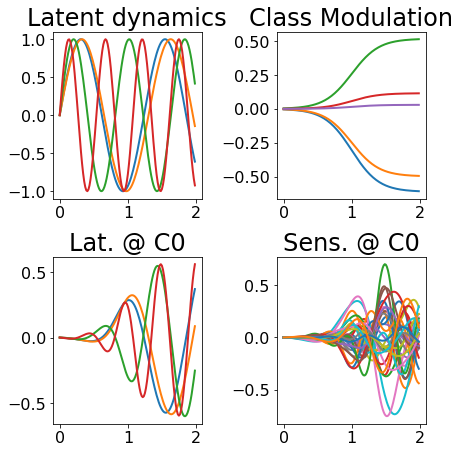

In [6]:
plt.subplot(2, 2, 1)
plt.plot(x, latent_protos.T)
plt.title("Latent dynamics")

plt.subplot(2, 2, 2)
plt.plot(x, latent_mods.T)
plt.title("Class Modulation")

plot_class_ix = 0
plt.subplot(2, 2, 3)
plt.plot(x, latent_class_dat[:, plot_class_ix, :].T)
plt.title(f"Lat. @ C{plot_class_ix}")

plt.subplot(2, 2, 4)
plt.plot(x, sensor_class_dat[plot_class_ix])
plt.title(f"Sens. @ C{plot_class_ix}")

plt.tight_layout()
plt.show()

We will draw samples from `sensor_class_dat` with added noise.
Compare the plotted example below to the plot from the lower-right pane above.

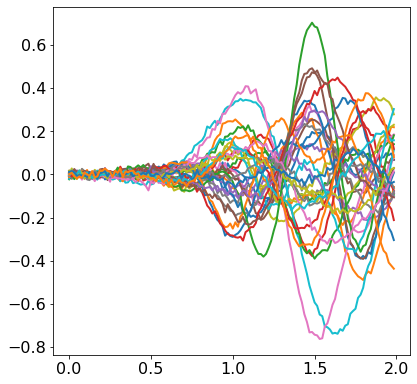

In [7]:
def draw_samples(class_idx, noise_std=0.01):
    dat = np.copy(sensor_class_dat[class_idx]).astype(np.float32)
    dat += np.random.normal(loc=0, scale=noise_std, size=dat.shape)
    return dat
    
plt.plot(x, draw_samples([plot_class_ix])[0])
plt.show()

In [8]:
N_TRIALS = 10000
BATCH_SIZE = 64

Y = np.random.randint(0, high=N_CLASSES, size=N_TRIALS)
X = draw_samples(Y)
dataset = tf.data.Dataset.from_tensor_slices((X, Y)).batch(BATCH_SIZE, drop_remainder=True)
dataset.element_spec

(TensorSpec(shape=(64, 128, 32), dtype=tf.float32, name=None),
 TensorSpec(shape=(64,), dtype=tf.int64, name=None))

## Sanity Check - GRU Classifier

We want to make sure that we can train a recurrent model to classify the data. As one of the main use-cases for us for an AE is for model pretraining and transfer to the classifier task, we would not usually *start* with classification. Here we are running a classifier first just to make sure our model isn't insane.

In [12]:
N_GRU = 50
N_EPOCHS = 2

K.clear_session()
model = tf.keras.Sequential(
    [tfkl.Input(shape=(n_timesteps, N_SENSORS)),
     tfkl.GRU(N_GRU, return_sequences=False),
     tfkl.Dense(N_CLASSES, activation='softmax')]
)
model.summary()
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
history = model.fit(dataset, epochs=N_EPOCHS)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                12600     
_________________________________________________________________
dense (Dense)                (None, 5)                 255       
Total params: 12,855
Trainable params: 12,855
Non-trainable params: 0
_________________________________________________________________
Train for 156 steps
Epoch 1/2
156/156 [==============================] - 4s 28ms/step - loss: 0.6110 - accuracy: 0.7302
Epoch 2/2
156/156 [==============================] - 4s 23ms/step - loss: 0.0129 - accuracy: 1.0000


In [13]:
pred_y = []
true_y = []
for batch_ix in range(X.shape[0] // BATCH_SIZE):
    _sl = np.s_[batch_ix * BATCH_SIZE : (batch_ix + 1) * BATCH_SIZE]
    pred_y.append(np.argmax(model.predict(X[_sl]), axis=1))
    true_y.append(Y[_sl])

tf.Tensor(
[[1952    0    0    0    0]
 [   0 2016    0    0    0]
 [   0    0 2000    0    0]
 [   0    0    0 2014    0]
 [   0    0    0    0 2002]], shape=(5, 5), dtype=int32)


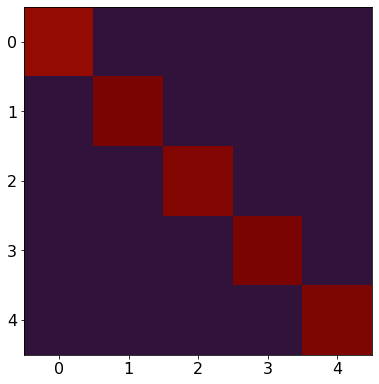

In [14]:
import indl.display  # To register 'turbo'


conf_mat = tf.math.confusion_matrix(np.array(true_y).flatten(), np.array(pred_y).flatten(), num_classes=N_CLASSES)
plt.imshow(conf_mat, cmap='turbo')
print(conf_mat)

## Basic Sequential Autoencoder

Before we get into the fancy **disentangled & variational** autoencoder, let's start with a simple one.

### Modify dataset

The autoencoder tries to reconstruct the input, so we need the 'labels' in the dataset to be a copy of the input. We do this by mapping a function to the dataset, where the function is a simple lambda that takes in x,y and returns x,x.

In [15]:
ae_dataset = dataset.map(lambda x, y: (x, x))
print(ae_dataset.element_spec)

(TensorSpec(shape=(64, 128, 32), dtype=tf.float32, name=None), TensorSpec(shape=(64, 128, 32), dtype=tf.float32, name=None))


Below we take the single timestep output of the encoder GRU and repeat it to be as long as the timesteps on the input. This is not the only way. TODO: Try other ways.

* Set decoder hidden state using encoder output, then feedback output of decoder into itself
* Set hidden state and/or first input, then the rest of the inputs are zeros.

[See here](https://stackoverflow.com/a/55000744/1256069)

In [16]:
N_EPOCHS = 20
LATENT_DIM = 50


K.clear_session()
model = tf.keras.Sequential([
    tfkl.Input(shape=(n_timesteps, N_SENSORS)),
    tfkl.GRU(LATENT_DIM, return_sequences=False),  # encoder: to latent
    tfkl.RepeatVector(n_timesteps),                # decoder a: upsample latent
    tfkl.GRU(N_SENSORS, return_sequences=True)     # decoder b: generate sequence
])
model.summary()
model.compile(loss='mse', 
              optimizer='adam')
history = model.fit(ae_dataset, epochs=N_EPOCHS)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                12600     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 128, 50)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128, 32)           8064      
Total params: 20,664
Trainable params: 20,664
Non-trainable params: 0
_________________________________________________________________
Train for 156 steps
Epoch 1/20
156/156 [==============================] - 8s 50ms/step - loss: 0.0107
Epoch 2/20
156/156 [==============================] - 7s 42ms/step - loss: 0.0105
Epoch 3/20
156/156 [==============================] - 7s 43ms/step - loss: 0.0105
Epoch 4/20
156/156 [==============================] - 6s 42ms/step - loss: 0.0106
Epoch 5/20
156/156 [==============

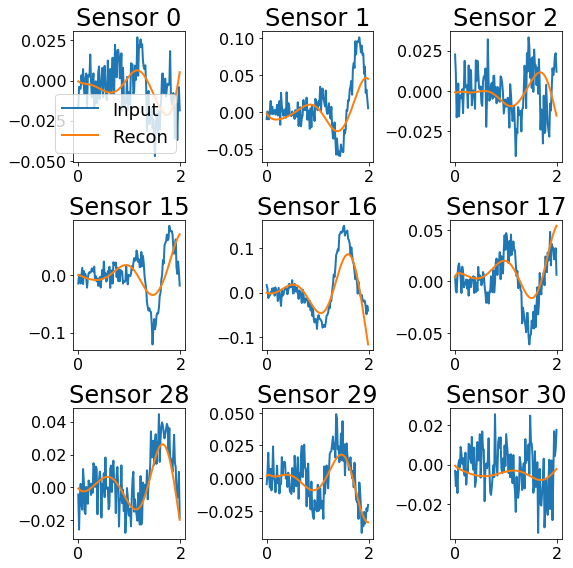

In [17]:
plt.figure(figsize=(8, 8))

trial_ix = 10
test_X = X[trial_ix, :, :][None, ...]
recon_X = model(test_X).numpy()
for chan_ix, chan_idx in enumerate([0, 1, 2, 15, 16, 17, 28, 29, 30]):
    plt.subplot(3, 3, chan_ix + 1)
    plt.plot(x, test_X[0, :, chan_idx], label="Input")
    plt.plot(x, recon_X[0, :, chan_idx], label="Recon")
    plt.title(f"Sensor {chan_idx}")
    if chan_ix == 0:
        plt.legend()

plt.tight_layout()
plt.show()

## Variational Autoencoder with vanilla TF and Keras

Next, we take the relatively large step of making the variational autoencoder using vanilla TF. This is quite a bit more involved than making it with TF-Probability, which we will see later.

Much of this was taken from online examples.

* [Official TF guide to convolutional VAE](https://www.tensorflow.org/tutorials/generative/cvae)
* [The Keras blog post on autoencoders](https://blog.keras.io/building-autoencoders-in-keras.html) (ctrl+F Variational autoencoder)
* [LSTM version of above](https://github.com/twairball/keras_lstm_vae/blob/master/lstm_vae/vae.py).

In [57]:
N_EPOCHS = 50
N_GRU = 100
LATENT_DIM = 96
# EPS_STD = 1.0

K.clear_session()

# Encoder
_input = tfkl.Input(shape=(n_timesteps, N_SENSORS))
_x = tfkl.GRU(LATENT_DIM * 2)(_input)
_mean, _log_sigma = tf.split(_x, num_or_size_splits=2, axis=1)
# _mean, _log_sigma = tfkl.Dense(LATENT_DIM)(_x), tfkl.Dense(LATENT_DIM)(_x)

_z = _mean + tf.random.normal(shape=(BATCH_SIZE, LATENT_DIM)) * tf.exp(_log_sigma * .5)

def sampling(args):
    z_mean, z_log_sigma = args
    eps = K.random_normal(shape=(BATCH_SIZE, LATENT_DIM), mean=0., stddev=EPS_STD)
    return z_mean + K.exp(z_log_sigma * .5) * eps  # TF guide has *.5 but Keras blog does not.

# Decoder
# _z = tfkl.Lambda(sampling)([_mean, _log_sigma])
_y = tfkl.RepeatVector(n_timesteps)(_z)
_y = tfkl.GRU(N_GRU, return_sequences=True)(_y)  # Seems to be necessary.
_y = tfkl.GRU(N_SENSORS, return_sequences=True)(_y)

# end-to-end model
vae_model = tf.keras.Model(_input, _y)
vae_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 32)]    0                                            
__________________________________________________________________________________________________
gru (GRU)                       (None, 192)          130176      input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_split (TensorFlowOp [(None, 96), (None,  0           gru[0][0]                        
__________________________________________________________________________________________________
tf_op_layer_mul (TensorFlowOpLa [(None, 96)]         0           tf_op_layer_split[0][1]          
______________________________________________________________________________________________

### Custom Loss

In [58]:
# We would need a custom training loop to properly ramp beta up to 1.0 over epochs.
# For now we just set it to a low enough constant that we can still get some
# reconstruction.
BETA = 0.001
kl_loss = -0.5 * K.mean(1 + _log_sigma - K.square(_mean) - K.exp(_log_sigma), axis=-1)
kl_loss = BETA * kl_loss
# Note, in Guillaume's formulation, the loss is first summed then mean (over what dim?)
    
vae_model.add_loss(kl_loss)
vae_model.compile(loss='mse', 
                  optimizer='nadam')

In [59]:
history = vae_model.fit(ae_dataset, epochs=N_EPOCHS)  # Target 0.001

Train for 156 steps
Epoch 1/50
156/156 [==============================] - 22s 144ms/step - loss: 0.0238
Epoch 2/50
156/156 [==============================] - 20s 131ms/step - loss: 0.0106
Epoch 3/50
156/156 [==============================] - 21s 132ms/step - loss: 0.0106
Epoch 4/50
156/156 [==============================] - 20s 130ms/step - loss: 0.0105
Epoch 5/50
156/156 [==============================] - 20s 131ms/step - loss: 0.0105
Epoch 6/50
156/156 [==============================] - 21s 132ms/step - loss: 0.0104
Epoch 7/50
156/156 [==============================] - 21s 132ms/step - loss: 0.0102
Epoch 8/50
156/156 [==============================] - 20s 131ms/step - loss: 0.0099
Epoch 9/50
156/156 [==============================] - 21s 134ms/step - loss: 0.0096
Epoch 10/50
156/156 [==============================] - 20s 128ms/step - loss: 0.0092
Epoch 11/50
156/156 [==============================] - 18s 118ms/step - loss: 0.0087
Epoch 12/50
156/156 [==============================] -

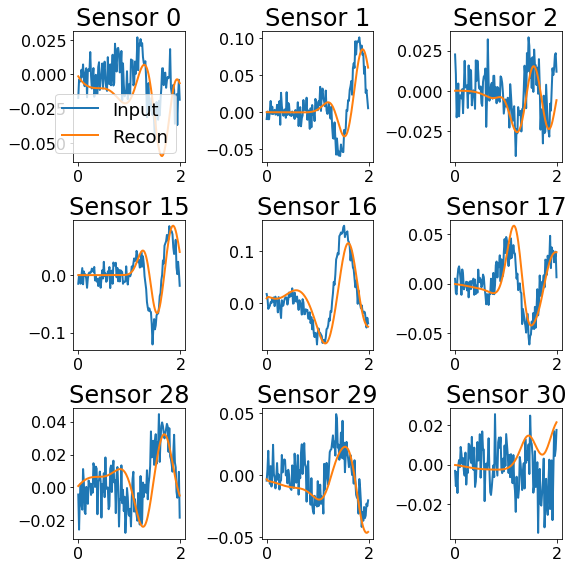

In [60]:
plt.figure(figsize=(8, 8))

trial_ix = 10
test_X = X[trial_ix, :, :][None, ...]
recon_X = vae_model(test_X).numpy()
for chan_ix, chan_idx in enumerate([0, 1, 2, 15, 16, 17, 28, 29, 30]):
    plt.subplot(3, 3, chan_ix + 1)
    plt.plot(x, test_X[0, :, chan_idx], label="Input")
    plt.plot(x, recon_X[0, :, chan_idx], label="Recon")
    plt.title(f"Sensor {chan_idx}")
    if chan_ix == 0:
        plt.legend()

plt.tight_layout()
plt.show()